In [1]:
import torch
from torchvision import transforms
import numpy as np
import pandas as pd
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as sklearn_mse
from scipy.ndimage import gaussian_filter

import os, sys
import itertools

sys.path.append(os.path.join(os.getcwd(), '../..'))

from ml_stuff.metadata_loader import MetadataLoader
from ml_stuff.batch_generator import WaveDataset
from ml_stuff.batch_factory import BatchFactory
from ml_stuff.positional_encoding import SinusoidalPositionalEmbedding

from tqdm import tqdm, trange
plt.rcParams['figure.dpi'] = 200

In [2]:
cuda_device = 'cuda:2'
batch_size = 16


In [3]:
asv50_stations = (2763, 2777, 2792, 2809, 2821, 2833, 2841)
stations = tuple((f'/storage/tartar/suslovai/input_nn/input_nn_ASV50/target_ASV50/{i}_target_meteo.csv',
                  f'/storage/tartar/suslovai/input_nn/input_nn_ASV50/radar_data_ASV50/{i}_full_len.npy')
                 for i in asv50_stations)

mdl = MetadataLoader(stations=stations, split=(0.7, 0.15, 0.15))

overall len: 12539
train len: 8772
validation len: 1877
test len: 1883


In [4]:
mdl.all_df

buoy_datetime         h  wind_speed           radar_datetime  \
0     2020-08-11 11:30:07.599  1.423883   63.613387  2020-08-11 11:30:07.125   
1     2020-08-11 11:30:08.000  1.423514   63.613387  2020-08-11 11:30:07.125   
2     2020-08-11 11:30:08.400  1.423043   63.613387  2020-08-11 11:30:09.235   
3     2020-08-11 11:30:08.799  1.422471   63.613387  2020-08-11 11:30:09.235   
4     2020-08-11 11:30:09.200  1.421793   63.613387  2020-08-11 11:30:09.235   
...                       ...       ...         ...                      ...   
12534 2020-08-23 12:48:08.400  1.475997   90.720754  2020-08-23 12:48:08.292   
12535 2020-08-23 12:48:08.799  1.474853   90.720754  2020-08-23 12:48:08.292   
12536 2020-08-23 12:48:09.200  1.473781   90.720754  2020-08-23 12:48:08.292   
12537 2020-08-23 12:48:09.599  1.472787   90.720754  2020-08-23 12:48:10.404   
12538 2020-08-23 12:48:10.000  1.471869   90.720754  2020-08-23 12:48:10.404   

       wind_direction  sin_wind_direction  cos_wind_direction      median  \
0            4.191072            0.895816            0.444426  111.248730   
1            4.191072            0.895816            0.444426  111.248730   
2            4.191072            0.895816            0.444426  111.248730   
3            4.191072            0.895816            0.444426  111.248730   
4            4.191072            0.895816            0.444426  111.248730   
...               ...                 ...                 ...         ...   
12534        9.366310            0.999921           -0.012579   61.701743   
12535        9.366310            0.999921           -0.012579   61.701743   
12536        9.366310            0.999921           -0.012579   61.701743   
12537        9.366310            0.999921           -0.012579   61.701743   
12538        9.366310            0.999921           -0.012579   61.701743   

       npy_index  station cruise  \
0             88     2763  ASV50   
1             88     2763  ASV50   
2             89     2763  ASV50   
3             89     2763  ASV50   
4             89     2763  ASV50   
...          ...      ...    ...   
12534        602     2841  ASV50   
12535        602     2841  ASV50   
12536        602     2841  ASV50   
12537        603     2841  ASV50   
12538        603     2841  ASV50   

                                                npy_path  hard_mining_weight  \
0      /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
1      /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
2      /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
3      /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
4      /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
...                                                  ...                 ...   
12534  /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
12535  /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
12536  /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
12537  /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   
12538  /storage/tartar/suslovai/input_nn/input_nn_ASV...                 1.0   

       last_predicted  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
12534             NaN  
12535             NaN  
12536             NaN  
12537             NaN  
12538             NaN  

[12539 rows x 14 columns]

In [6]:
model = torch.load('/app/scripts/anikin/Wavedar/ml_stuff/logs/misc_20220808_122926_62/model_ep14.pt')
model.to(cuda_device)
if hasattr(model.resnet.conv1, 'in_channels'):
    encoder_dimension = (model.resnet.conv1.in_channels - 1) // 4
else:
    encoder_dimension = model.encoder_dimension

In [7]:
model

ResnetRegressor(
  (resnet): ResNet(
    (conv1): CoordConv2d(
      (conv): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (encoder): SinusoidalPositionalEmbedding()
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): CoordConv2d(
          (conv): Conv2d(72, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (encoder): SinusoidalPositionalEmbedding()
        )
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): CoordConv2d(
          (conv): Conv2d(72, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (encoder): SinusoidalPositionalEmbedding()
        )
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [10]:
val_set = WaveDataset(wave_frame=mdl.validation,
                      batch_size=batch_size,
                      do_shuffle=True)

validation_batch_factory = BatchFactory(val_set,
                                        cuda_device,
                                        do_augment=False,
                                        preprocess_worker_number=4,
                                        to_variable=False)

In [11]:
# validation_batch_factory.stop()

In [12]:
val_set.wave_frame['predicted'] = np.nan

for _ in trange(len(val_set) // batch_size + 1):
    batch = validation_batch_factory.cuda_queue.get()
    predicted = model(batch.images).detach().cpu().numpy().squeeze()
    
    updater_df = pd.DataFrame({'predicted': predicted.tolist()})
    updater_df.set_index(pd.Index(batch.train_frame_indexes), inplace=True)
    val_set.wave_frame.update(updater_df)

  0%|                                                 | 0/118 [00:00<?, ?it/s]/app/scripts/anikin/venv_39/lib/python3.9/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Mask with shape torch.Size([16, 1, 480, 960]) cached


100%|███████████████████████████████████████| 118/118 [00:43<00:00,  2.74it/s]


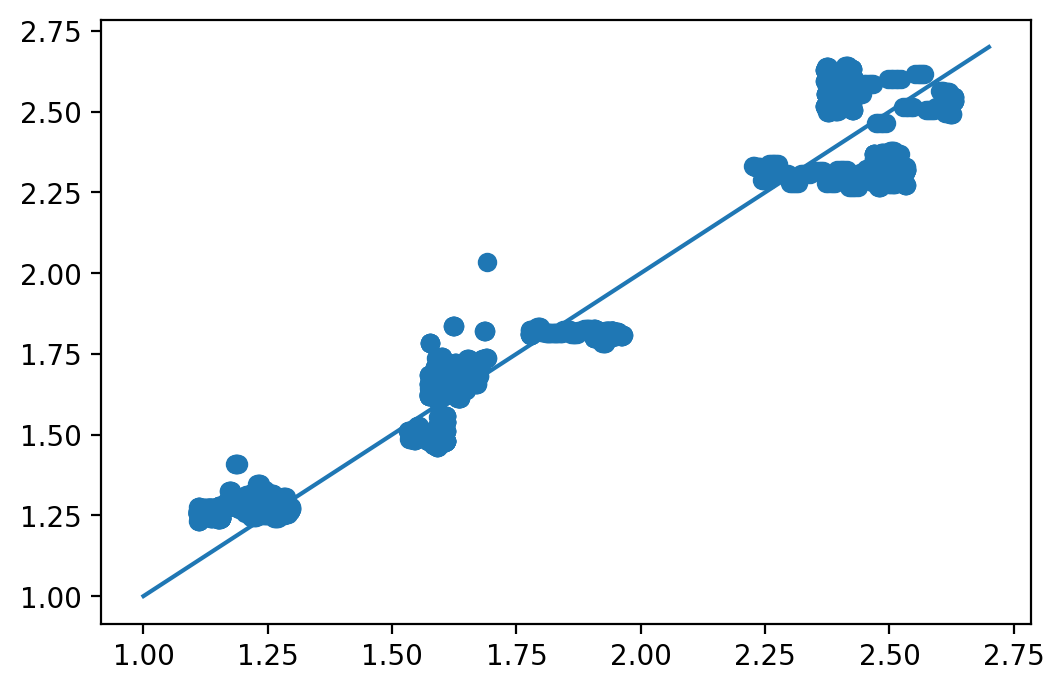

In [13]:
plt.scatter(val_set.wave_frame.h, val_set.wave_frame.predicted)
plt.plot([1., 2.7], [1., 2.7])

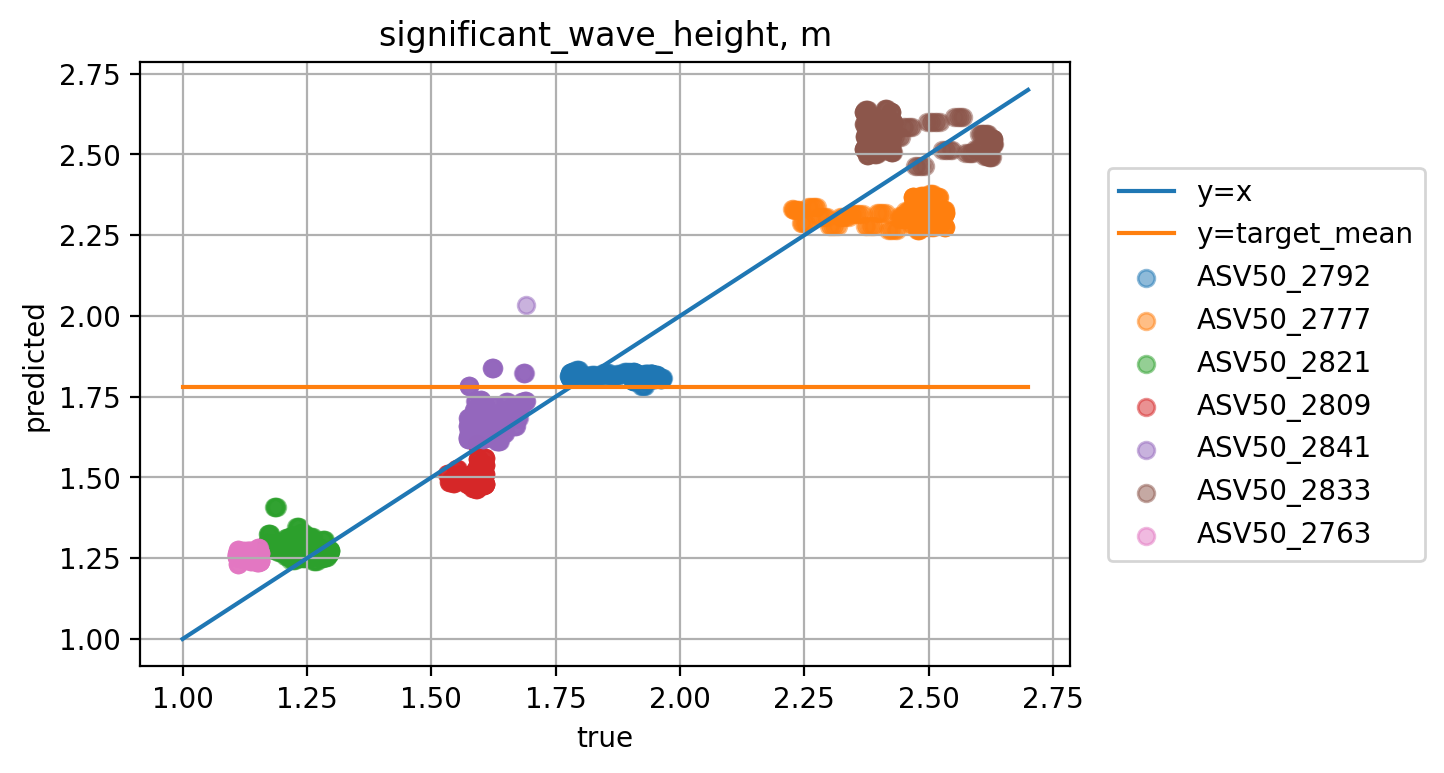

In [14]:
for cruise in val_set.wave_frame.cruise.unique():
    for station in val_set.wave_frame.station.unique():
        selection = (val_set.wave_frame.station == station) & (val_set.wave_frame.cruise == cruise)
        plt.scatter(val_set.wave_frame[selection].h, val_set.wave_frame[selection].predicted, 
                    label=f'{cruise}_{station}',
                    alpha=0.5,
                   )
        
plt.xlabel('true')
plt.ylabel('predicted')
plt.title('significant_wave_height, m')
plt.grid()
plt.plot([1., 2.7], [1., 2.7], label='y=x')

mean = [val_set.wave_frame.h.mean()]
plt.plot([1., 2.7], [mean, mean], label='y=target_mean')

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [15]:
val_set.wave_frame.h.min(), val_set.wave_frame.h.max()

(1.1090435515884036, 2.6306095207880507)

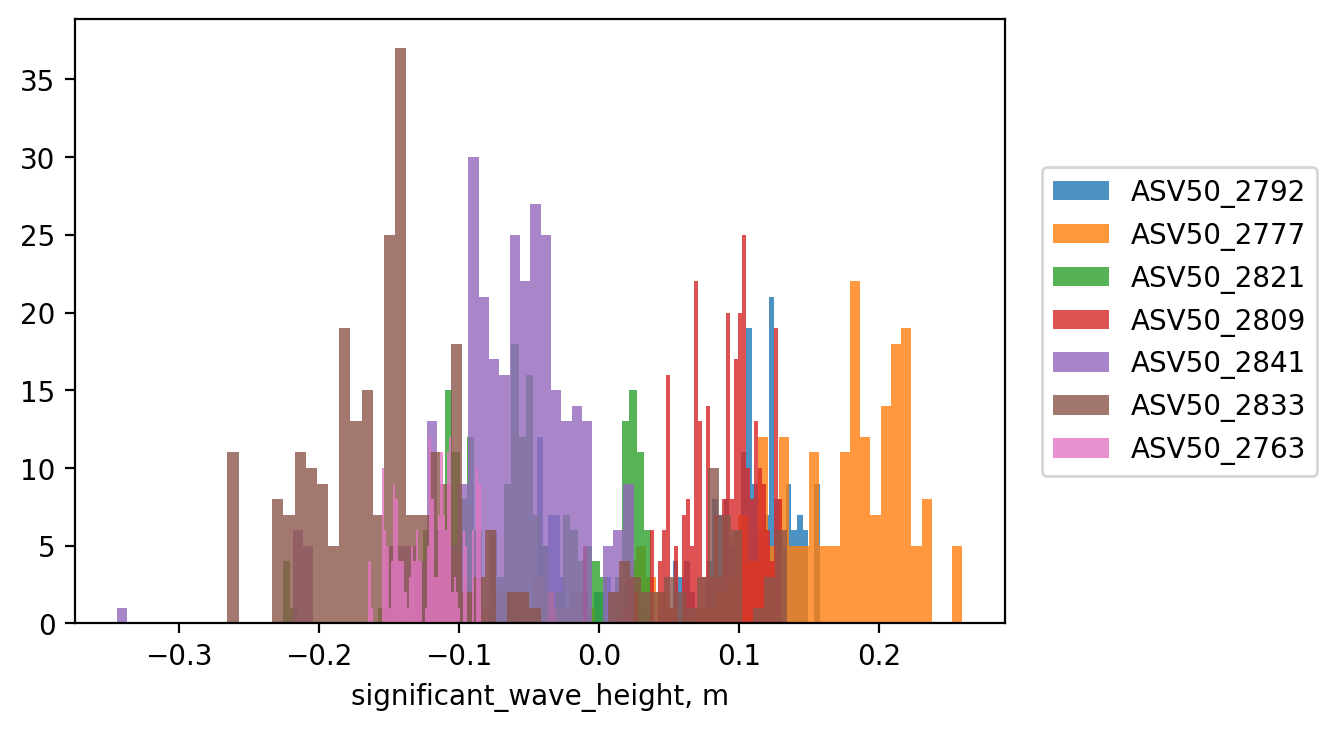

In [16]:
for cruise in val_set.wave_frame.cruise.unique():
    for station in val_set.wave_frame.station.unique():
        selection = (val_set.wave_frame.station == station) & (val_set.wave_frame.cruise == cruise)
        plt.hist((val_set.wave_frame[selection].h - val_set.wave_frame[selection].predicted).tolist(),
                 bins=50, density=False, alpha=0.8, label=f'{cruise}_{station}')

plt.xlabel('significant_wave_height, m')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [20]:
df = val_set.wave_frame.dropna(subset=['h', 'predicted'])
print(f'model mse = {sklearn_mse(df.h, df.predicted):.4f}')
print(f'mean mse = {sklearn_mse(df.h, [df.h.mean()] * df.shape[0]):.4f}')

model mse = 0.0137
mean mse = 0.2303


/app/scripts/anikin/venv_39/lib/python3.9/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


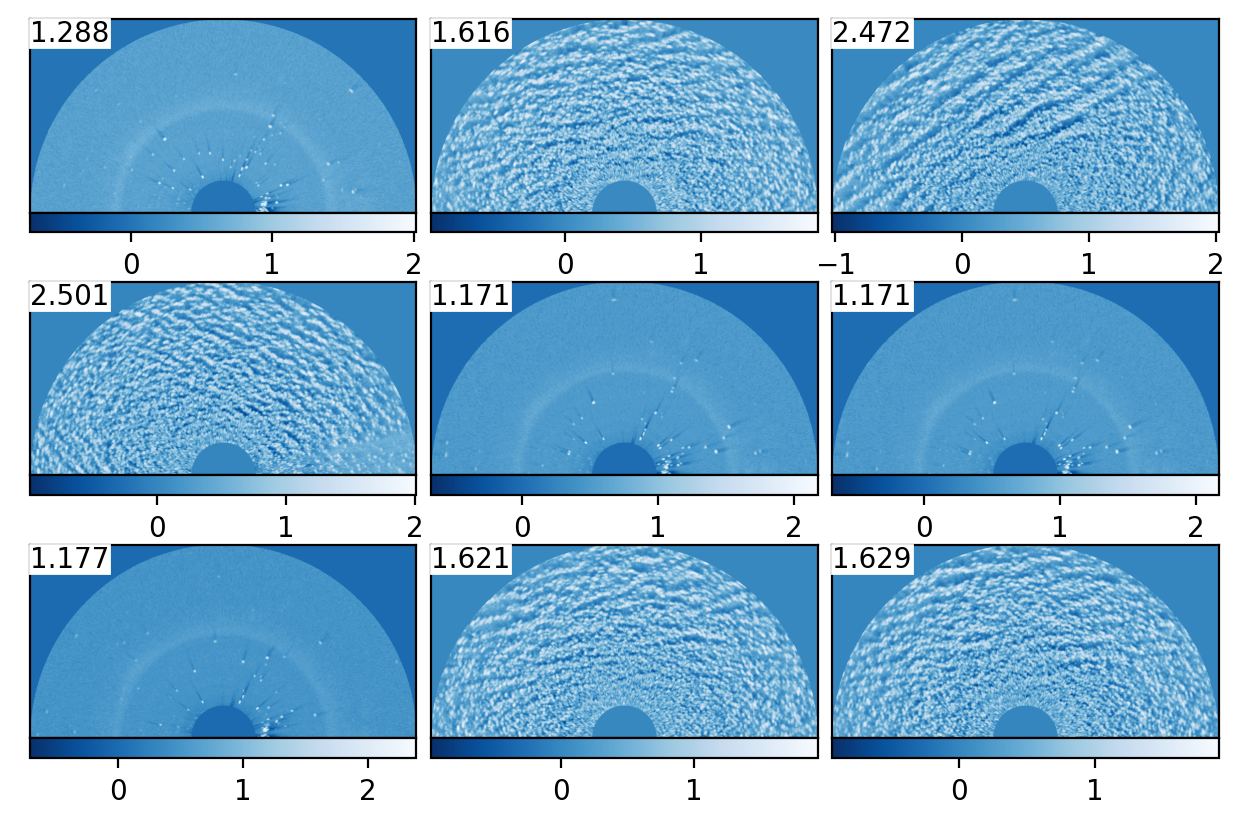

In [21]:
def my_show(batch, slice_, ):
    waves = batch.significant_wave_height[slice_]
    imgs = batch.images[slice_].detach().cpu().numpy()
    fig = plt.figure()
    fig.set_tight_layout(tight={'pad': -0.1,})
    square_size = np.ceil(np.sqrt(imgs.shape[0])).astype(int)
    
    for i in range(imgs.shape[0]):
        ax = fig.add_subplot(square_size, square_size, i + 1)
        im = ax.imshow(imgs[i, 0, :, :], cmap='Blues_r', 
                       # origin='lower'
                      )
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        ax.text(min(ax.get_xlim()), min(ax.get_ylim()),
                f'{waves[i].item():.3f}',
                horizontalalignment='left',
                verticalalignment='top',
                bbox={'pad': 0, 'color': 'white'}
               )
        fig.colorbar(im, ax=ax, orientation='horizontal', pad=0)
        
        
batch = validation_batch_factory.cuda_queue.get()
my_show(batch, slice(None, 9, None))

In [22]:
def compute_saliency_map(model, image_tensor: torch.Tensor):
    
    image_tensor.requires_grad_(True)
    y = model(image_tensor)
    (grad, ) = torch.autograd.grad(y, inputs=image_tensor, create_graph=False)
    
    saliency_map = torch.abs(grad.cpu().detach())
    
    return saliency_map

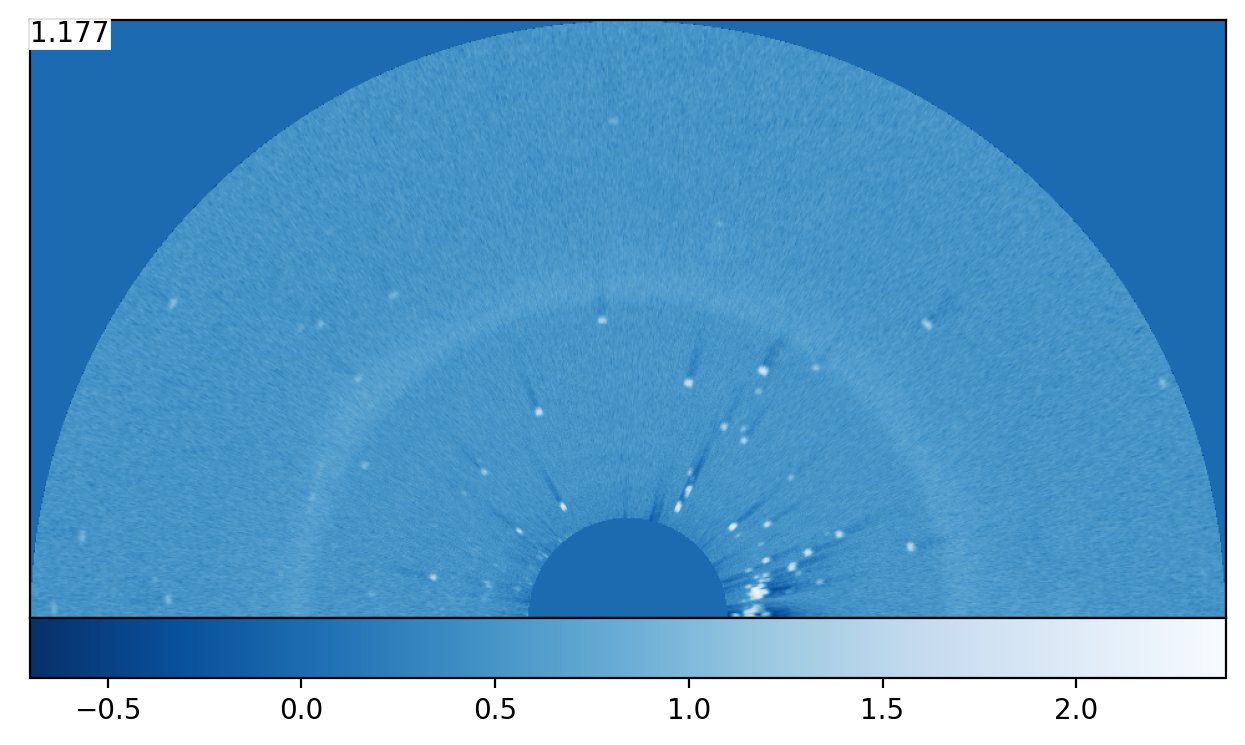

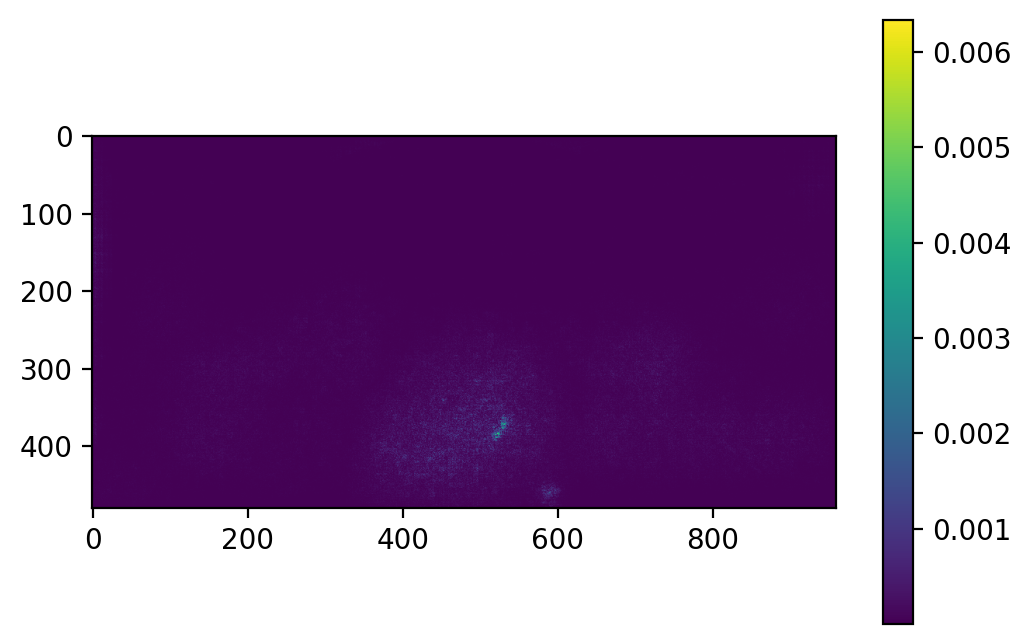

In [23]:
slice_ = slice(6, 7, None)

sal_map = compute_saliency_map(model, batch.images[slice_])
sal_map.shape

my_show(batch, slice_)
plt.show()

for i in range(1):
    data = sal_map[0, i, :, :].numpy()
    plt.imshow(data)
    plt.colorbar()
    plt.show()

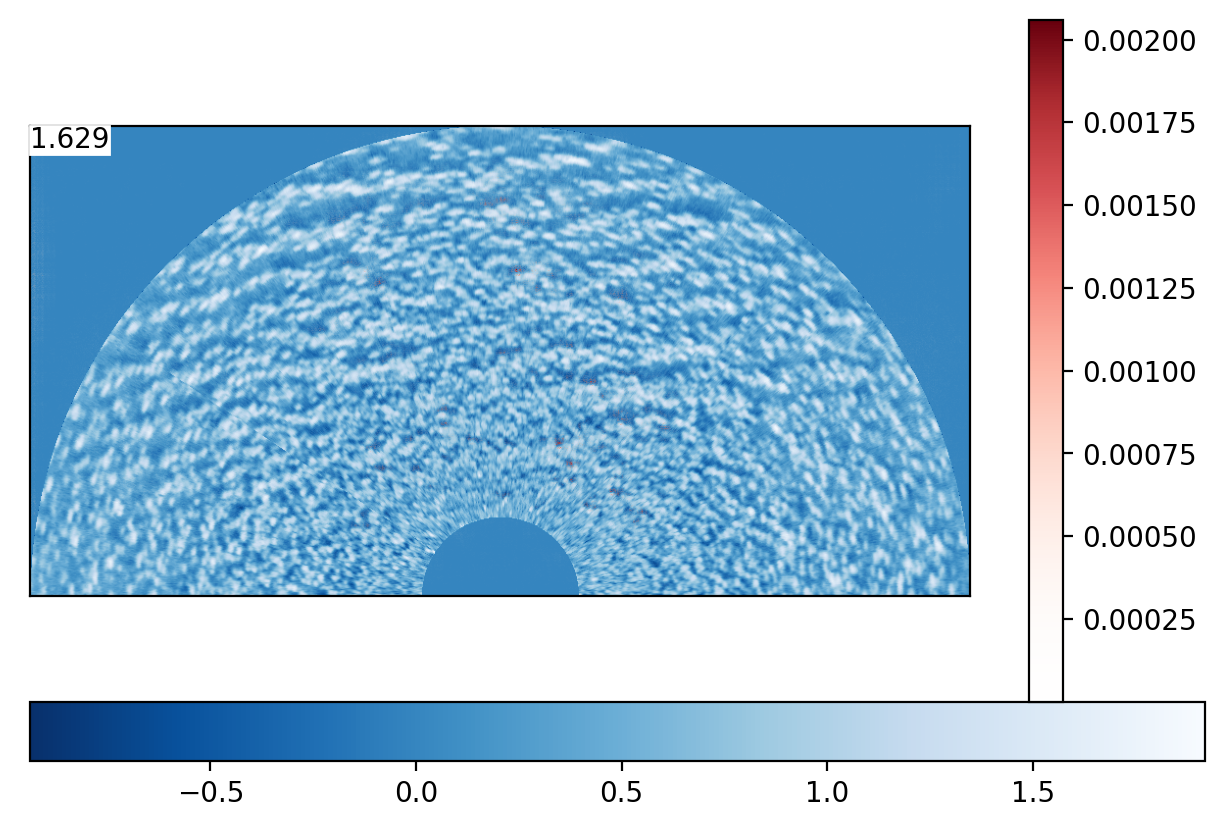

In [42]:
slice_ = slice(8, 9, None)

sal_map = compute_saliency_map(model, batch.images[slice_])
sal_map.shape

my_show(batch, slice_)

data = sal_map[0, 0, :, :].numpy()

# get colormap
ncolors = 256
color_array = plt.get_cmap('Reds')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0, 1,ncolors)


# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='reds_alpha',colors=color_array)

plt.imshow(data, cmap=map_object)
plt.colorbar()
plt.show()

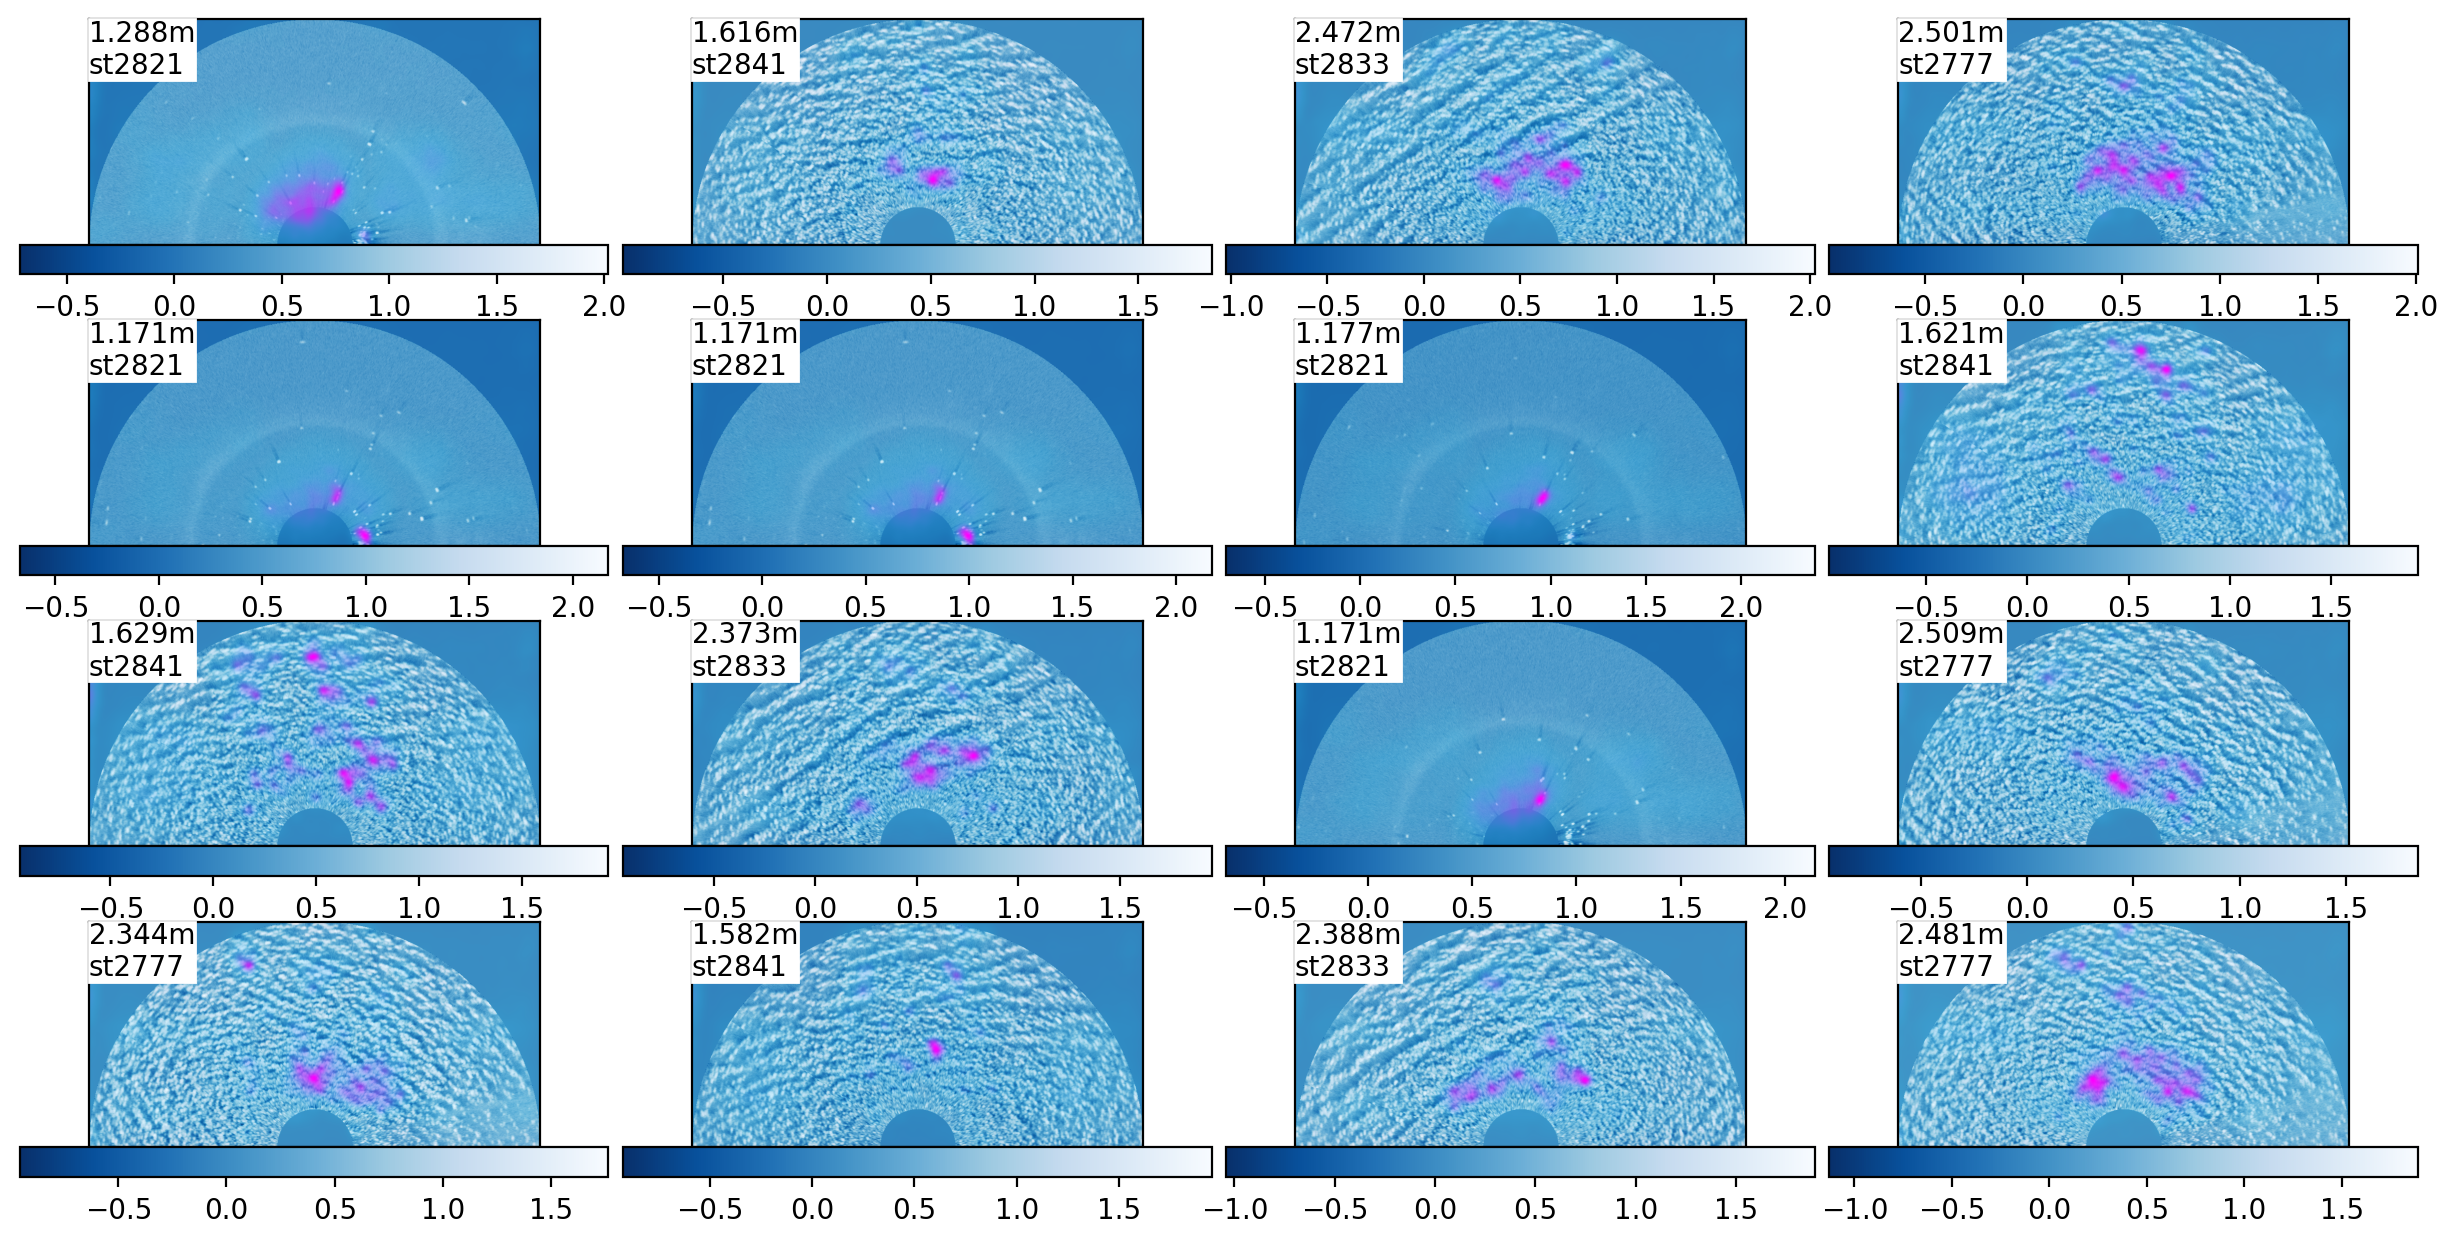

In [65]:
def my_show_salincy(batch, slice_, ):
    waves = batch.significant_wave_height[slice_]
    imgs = batch.images[slice_].detach().cpu().numpy()
    fig = plt.figure(figsize=[12, 6])
    fig.set_tight_layout(tight={'pad': -0.1,})
    square_size = np.ceil(np.sqrt(imgs.shape[0])).astype(int)
    
    # get colormap
    ncolors = 256
    color_array = plt.get_cmap('cool')(range(ncolors))
    # change alpha values
    color_array[:,-1] = np.linspace(0, 1,ncolors)


    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name='alpha',colors=color_array)
    
    for i in range(imgs.shape[0]):
        ax = fig.add_subplot(square_size, square_size, i + 1)
        im = ax.imshow(imgs[i, 0, :, :], cmap='Blues_r', 
                       # origin='lower'
                      )
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        station = val_set.wave_frame.loc[batch.train_frame_indexes[slice_][i]].station
        ax.text(min(ax.get_xlim()), min(ax.get_ylim()),
                f'{waves[i].item():.3f}m\nst{station}',
                horizontalalignment='left',
                verticalalignment='top',
                bbox={'pad': 0, 'color': 'white'}
               )
        fig.colorbar(im, ax=ax, orientation='horizontal', pad=0)
        
        sal_map = compute_saliency_map(model, batch.images[i: i + 1, : , :, :]).numpy().squeeze()
        sal_map = gaussian_filter(sal_map, 8, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
        ax.imshow(sal_map, cmap=map_object)
        
my_show_salincy(batch, slice(0, 16, 1))